All Packages I might need

In [1]:
import numpy as np
from numpy.random import randn

import pandas as pd
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix

import math as m

import time as t

In [2]:
NBA_DF=pd.DataFrame(pd.read_csv('NBA_Scores_Clean.csv'))
NBA_DF=NBA_DF.drop(['HomeConf','HomeDiv','RoadCOnf','RoadDiv','HomeRslt'], axis=1)

In [3]:
NBA_DF_Home=NBA_DF.drop(['RoadTeam'],axis=1)
NBA_DF_Home=NBA_DF_Home.rename(columns={'HomeTeam':'Team','RoadPts':'HomeAgainst','HomePts':'HomeFor'})
NBA_DF_Home['For']=NBA_DF_Home.HomeFor
NBA_DF_Home['Against']=NBA_DF_Home.HomeAgainst
NBA_DF_Home['HomeResult']=np.where(NBA_DF_Home.HomeFor>NBA_DF_Home.HomeAgainst,1,0)
NBA_DF_Home['Result']=NBA_DF_Home.HomeResult
NBA_DF_Home['AwayFor']=np.NaN #empty road columns
NBA_DF_Home['AwayAgainst']=np.NaN
NBA_DF_Home['AwayResult']=np.NaN

NBA_DF_Away=NBA_DF.drop(['HomeTeam'],axis=1)
NBA_DF_Away=NBA_DF_Away.rename(columns={'RoadTeam':'Team','RoadPts':'AwayFor','HomePts':'AwayAgainst'})
NBA_DF_Away['For']=NBA_DF_Away.AwayFor
NBA_DF_Away['Against']=NBA_DF_Away.AwayAgainst
NBA_DF_Away['AwayResult']=np.where(NBA_DF_Away.AwayFor>NBA_DF_Away.AwayAgainst,1,0)
NBA_DF_Away['Result']=NBA_DF_Away.AwayResult
NBA_DF_Away['HomeFor']=np.NaN #empty home columns
NBA_DF_Away['HomeAgainst']=np.NaN
NBA_DF_Away['HomeResult']=np.NaN

NBA_DF_All=NBA_DF_Home.append(NBA_DF_Away,ignore_index=True)

In [4]:
#Home win percentage for NBA
NBA_DF_All.HomeResult.mean(),NBA_DF_All.AwayResult.mean()

(0.5863938203008537, 0.4136061796991462)

In [5]:
NBA_Results=NBA_DF_All.groupby(['Team','Season']).mean()

In [6]:
test2=[]
for p in range(1,21):
    NBA_Results['PythagWin']=NBA_Results.For**p/(NBA_Results.For**p+NBA_Results.Against**p)
    NBA_Results['SqErr']=(NBA_Results.Result-NBA_Results.PythagWin)**2
    test2.append({'p':p,'SqErr':sum(NBA_Results.SqErr)})
test2_df=pd.DataFrame(test2)
test2_df

,p,SqErr
0,1,3.635525
1,2,3.104133
2,3,2.620387
3,4,2.184599
4,5,1.796597
5,6,1.455760
6,7,1.161052
7,8,0.911073
8,9,0.704112
9,10,0.538204


For NBA, a pythagorean values of 14 yields the best win percentage predctions. PF^14/(PF^14+PA^14)

In [7]:
NBA_DF=NBA_DF_All.groupby(['Season','Team']).mean()

All single-computation commands

In [8]:
NBA_DF.reset_index(level=0, inplace=True)
p_NBA=14

NBA_DF['PythagHome']=NBA_DF.apply(lambda x: x['HomeFor']**p_NBA/(x['HomeFor']**p_NBA+x['HomeAgainst']**p_NBA),axis=1)
NBA_DF['PythagAway']=NBA_DF.apply(lambda x: x['AwayFor']**p_NBA/(x['AwayFor']**p_NBA+x['AwayAgainst']**p_NBA),axis=1)
NBA_DF['Pythag']=NBA_DF.apply(lambda x: x['For']**p_NBA/(x['For']**p_NBA+x['Against']**p_NBA),axis=1)

NBA_DF["SeasRank"] = NBA_DF.groupby(['Season'])["Pythag"].rank(method='first', ascending=False)

NBA_Averages=NBA_DF.groupby('SeasRank').mean()

HF_Avg=NBA_DF.HomeFor.mean()
HA_Avg=NBA_DF.HomeAgainst.mean()

NBA_Sched=pd.DataFrame(pd.read_csv('NBA_Schedule.CSV'))

def Sim(F,A):
    r=np.random.rand()
    p=F**p_NBA/(F**p_NBA+A**p_NBA)
    if r<p:
        return 1
    elif r>p:
        return 0
    else:
        return 0.5
    
def FullGameSim(HF,HA,AF,AA,Avg_HF,Avg_HA):
    HF_Adj=(HF*AA)/Avg_HF
    AF_Adj=(AF*HA)/Avg_HA
    g=Sim(HF_Adj,AF_Adj)
    return g,HF_Adj,AF_Adj



All iterative simulations

In [9]:
t_start=t.time()
n_sim=10
Results=[]
for sim in range(0,n_sim):

    NBA_Ranks=pd.DataFrame(data={'TeamID':NBA_Sched['RoadID'].unique(),'TeamRank':np.random.rand(30),'Conf':np.NAN,'Div':np.NAN})
    NBA_Ranks.TeamRank=NBA_Ranks.TeamRank.rank(method='first', ascending=False) #replace randoms with ranks

    for i in range(0,30):
        NBA_Ranks.iloc[i,2]=NBA_Sched.loc[NBA_Sched['HomeID']==NBA_Ranks.iloc[i,0]].iloc[0,1]
        NBA_Ranks.iloc[i,3]=NBA_Sched.loc[NBA_Sched['HomeID']==NBA_Ranks.iloc[i,0]].iloc[0,2]

    NBA_Ranks=NBA_Ranks.sort_values(by=['TeamID'])
    NBA_Ranks

    NBA_Sched['AwayRank']=NBA_Sched.apply(lambda x: NBA_Ranks.loc[NBA_Ranks['TeamID'] == x['RoadID']].iloc[0,1] ,axis=1)
    NBA_Sched['HomeRank']=NBA_Sched.apply(lambda x: NBA_Ranks.loc[NBA_Ranks['TeamID'] == x['HomeID']].iloc[0,1] ,axis=1)

    NBA_Sched['HomeResult']=NBA_Sched.apply(lambda x: FullGameSim(
        NBA_Averages.iloc[int(x['HomeRank']-1),1]
        ,NBA_Averages.iloc[int(x['HomeRank']-1),2]
        ,NBA_Averages.iloc[int(x['AwayRank']-1),7]
        ,NBA_Averages.iloc[int(x['AwayRank']-1),8]
        ,HF_Avg,HA_Avg)[0], axis=1)

    NBA_Ranks['Result']=np.zeros(30)
    for i in range(1,31):
        NBA_Ranks.iloc[i-1,4]=(NBA_Sched.groupby('HomeRank').mean().HomeResult[NBA_Ranks.iloc[i-1,1]]+
                                   (1-NBA_Sched.groupby('AwayRank').mean().HomeResult[NBA_Ranks.iloc[i-1,1]]))/2
    NBA_Ranks['Wins']=82*NBA_Ranks['Result']
    NBA_Ranks['Losses']=82*(1-NBA_Ranks['Result'])
    NBA_Ranks['NBARank']=NBA_Ranks.Result.rank(method='first', ascending=False)
    NBA_Ranks['ConfSeed']=NBA_Ranks.groupby('Conf').Result.rank(method='first', ascending=False)
    NBA_Ranks['DivRank']=NBA_Ranks.groupby(['Conf','Div']).Result.rank(method='first', ascending=False)
    NBA_Ranks['PlayoffResult']='None' #Say "none" for each team. Playoff teams updated later
    NBA_Ranks['Sim']=sim #save run number

    NBA_Post_Sched=pd.read_excel('NBA_playoffs.xlsx')
    #Playoff Simulations
    NBA_Post_Sched['Result']=np.NAN

    #Set up seeds
    for r in range(0,56):
        NBA_Post_Sched.iloc[r,6]=NBA_Ranks.loc[(NBA_Ranks.Conf==NBA_Post_Sched.iloc[r,0])&
            (NBA_Ranks.ConfSeed==NBA_Post_Sched.iloc[r,3])].iloc[0,0] #Higher Seeds
        NBA_Post_Sched.iloc[r,7]=NBA_Ranks.loc[(NBA_Ranks.Conf==NBA_Post_Sched.iloc[r,0])&
            (NBA_Ranks.ConfSeed==NBA_Post_Sched.iloc[r,4])].iloc[0,0] #Lower Seeds

    #WQF1 1v8
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[0,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[0,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(0,7):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CQF' #Note that lower seed lost in CQF
            NBA_Post_Sched.iloc[56:63,3]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
            NBA_Post_Sched.iloc[56:63,6]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            West_Win=1 #Save that higher seed won
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CQF' #Note that higher seed lost in CQF
            NBA_Post_Sched.iloc[56:63,4]=NBA_Post_Sched.iloc[r,4] #Lower seed to WSF1
            NBA_Post_Sched.iloc[56:63,7]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            West_Win=8 #Save that lower seed won
            break

    #WQF2 4v5
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[7,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[7,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(7,14):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CQF'
            if West_Win==1: #will be lower seed
                NBA_Post_Sched.iloc[56:63,4]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
                NBA_Post_Sched.iloc[56:63,7]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[56:63,3]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
                NBA_Post_Sched.iloc[56:63,6]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CQF'
            if West_Win==1: #will be lower seed
                NBA_Post_Sched.iloc[56:63,4]=NBA_Post_Sched.iloc[r,4] #Higher seed to WSF1
                NBA_Post_Sched.iloc[56:63,7]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[56:63,3]=NBA_Post_Sched.iloc[r,4] #Higher seed to WSF1
                NBA_Post_Sched.iloc[56:63,6]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            break

    #WQF3 2v7
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[14,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[14,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(14,21):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CQF'
            NBA_Post_Sched.iloc[63:70,3]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
            NBA_Post_Sched.iloc[63:70,6]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            West_Win=2 #Save that higher seed won
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CQF'
            NBA_Post_Sched.iloc[63:70,4]=NBA_Post_Sched.iloc[r,4] #Lower seed to WSF1
            NBA_Post_Sched.iloc[63:70,7]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            West_Win=7 #Save that lower seed won
            break

    #WQF4 3v6
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[21,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[21,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(21,28):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CQF'
            if West_Win==2: #will be lower seed
                NBA_Post_Sched.iloc[63:70,4]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
                NBA_Post_Sched.iloc[63:70,7]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[63:70,3]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
                NBA_Post_Sched.iloc[63:70,6]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CQF'
            if West_Win==2: #will be lower seed
                NBA_Post_Sched.iloc[63:70,4]=NBA_Post_Sched.iloc[r,4] #Higher seed to WSF1
                NBA_Post_Sched.iloc[63:70,7]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[63:70,3]=NBA_Post_Sched.iloc[r,4] #Higher seed to WSF1
                NBA_Post_Sched.iloc[63:70,6]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            break

    #EQF1 1v8
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[28,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[28,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(28,35):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CQF'
            NBA_Post_Sched.iloc[70:77,3]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
            NBA_Post_Sched.iloc[70:77,6]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            East_Win=1 #Save that higher seed won
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CQF'
            NBA_Post_Sched.iloc[70:77,4]=NBA_Post_Sched.iloc[r,4] #Lower seed to WSF1
            NBA_Post_Sched.iloc[70:77,7]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            East_Win=8 #Save that lower seed won
            break

    #EQF2 4v5
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[35,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[35,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(35,42):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CQF'
            if East_Win==1: #will be lower seed
                NBA_Post_Sched.iloc[70:77,4]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
                NBA_Post_Sched.iloc[70:77,7]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[70:77,3]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
                NBA_Post_Sched.iloc[70:77,6]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CQF'
            if East_Win==1: #will be lower seed
                NBA_Post_Sched.iloc[70:77,4]=NBA_Post_Sched.iloc[r,4] #Higher seed to WSF1
                NBA_Post_Sched.iloc[70:77,7]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[70:77,3]=NBA_Post_Sched.iloc[r,4] #Higher seed to WSF1
                NBA_Post_Sched.iloc[70:77,6]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            break

    #EQF3 2v7
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[42,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[42,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(42,49):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CQF'
            NBA_Post_Sched.iloc[77:84,3]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
            NBA_Post_Sched.iloc[77:84,6]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            East_Win=2 #Save that higher seed won
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CQF'
            NBA_Post_Sched.iloc[77:84,4]=NBA_Post_Sched.iloc[r,4] #Lower seed to WSF1
            NBA_Post_Sched.iloc[77:84,7]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            East_Win=7 #Save that lower seed won
            break

    #EQF2 3v6
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[49,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[49,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(49,56):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CQF'
            if East_Win==2: #will be lower seed
                NBA_Post_Sched.iloc[77:84,4]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
                NBA_Post_Sched.iloc[77:84,7]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[77:84,3]=NBA_Post_Sched.iloc[r,3] #Higher seed to WSF1
                NBA_Post_Sched.iloc[77:84,6]=NBA_Post_Sched.iloc[r,6] #Fill in Team ID
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CQF'
            if East_Win==2: #will be lower seed
                NBA_Post_Sched.iloc[77:84,4]=NBA_Post_Sched.iloc[r,4] #Higher seed to WSF1
                NBA_Post_Sched.iloc[77:84,7]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[77:84,3]=NBA_Post_Sched.iloc[r,4] #Higher seed to WSF1
                NBA_Post_Sched.iloc[77:84,6]=NBA_Post_Sched.iloc[r,7] #Fill in Team ID
            break

    #WSF1
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[56,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[56,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(56,63):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CSF'
            West_Win=NBA_Post_Sched.iloc[r,3] #Save that higher seed won
            West_Win_ID=NBA_Post_Sched.iloc[r,6]
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CSF'
            West_Win=NBA_Post_Sched.iloc[r,4] #Save that lower seed won
            West_Win_ID=NBA_Post_Sched.iloc[r,7]
            break

    #WSF2
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[63,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[63,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(63,70):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CSF'
            if West_Win<NBA_Post_Sched.iloc[r,3]: #will be lower seed
                NBA_Post_Sched.iloc[84:91,4]=NBA_Post_Sched.iloc[r,3]
                NBA_Post_Sched.iloc[84:91,7]=NBA_Post_Sched.iloc[r,6]
                NBA_Post_Sched.iloc[84:91,3]=West_Win #higher seed from WS1
                NBA_Post_Sched.iloc[84:91,6]=West_Win_ID #higher team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[84:91,3]=NBA_Post_Sched.iloc[r,3]
                NBA_Post_Sched.iloc[84:91,6]=NBA_Post_Sched.iloc[r,6]
                NBA_Post_Sched.iloc[84:91,4]=West_Win #lower seed fron WS1
                NBA_Post_Sched.iloc[84:91,7]=West_Win_ID #lower team ID
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CSF'
            if West_Win<NBA_Post_Sched.iloc[r,4]: #will be lower seed
                NBA_Post_Sched.iloc[84:91,4]=NBA_Post_Sched.iloc[r,4]
                NBA_Post_Sched.iloc[84:91,7]=NBA_Post_Sched.iloc[r,7]
                NBA_Post_Sched.iloc[84:91,3]=West_Win #higher seed from WS1
                NBA_Post_Sched.iloc[84:91,6]=West_Win_ID #higher team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[84:91,3]=NBA_Post_Sched.iloc[r,4]
                NBA_Post_Sched.iloc[84:91,6]=NBA_Post_Sched.iloc[r,7]
                NBA_Post_Sched.iloc[84:91,4]=West_Win #lower seed fron WS1
                NBA_Post_Sched.iloc[84:91,7]=West_Win_ID #lower team ID
            break

    #ESF1
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[70,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[70,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(70,77):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CSF'
            East_Win=NBA_Post_Sched.iloc[r,3] #Save that higher seed won
            East_Win_ID=NBA_Post_Sched.iloc[r,6]
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CSF'
            East_Win=NBA_Post_Sched.iloc[r,4] #Save that lower seed won
            East_Win_ID=NBA_Post_Sched.iloc[r,7]
            break

    #ESF2
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[77,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[77,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(77,84):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CSF'
            if East_Win<NBA_Post_Sched.iloc[r,3]: #will be lower seed
                NBA_Post_Sched.iloc[91:98,4]=NBA_Post_Sched.iloc[r,3]
                NBA_Post_Sched.iloc[91:98,7]=NBA_Post_Sched.iloc[r,6]
                NBA_Post_Sched.iloc[91:98,3]=East_Win #higher seed from ES1
                NBA_Post_Sched.iloc[91:98,6]=East_Win_ID #higher team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[91:98,3]=NBA_Post_Sched.iloc[r,3]
                NBA_Post_Sched.iloc[91:98,6]=NBA_Post_Sched.iloc[r,6]
                NBA_Post_Sched.iloc[91:98,4]=East_Win #lower seed fron ES1
                NBA_Post_Sched.iloc[91:98,7]=East_Win_ID #lower team ID
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CSF'
            if East_Win<NBA_Post_Sched.iloc[r,4]: #will be lower seed
                NBA_Post_Sched.iloc[91:98,4]=NBA_Post_Sched.iloc[r,4]
                NBA_Post_Sched.iloc[91:98,7]=NBA_Post_Sched.iloc[r,7]
                NBA_Post_Sched.iloc[91:98,3]=East_Win #higher seed from ES1
                NBA_Post_Sched.iloc[91:98,6]=East_Win_ID #higher team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[91:98,3]=NBA_Post_Sched.iloc[r,4]
                NBA_Post_Sched.iloc[91:98,6]=NBA_Post_Sched.iloc[r,7]
                NBA_Post_Sched.iloc[91:98,4]=East_Win #lower seed fron ES1
                NBA_Post_Sched.iloc[91:98,7]=East_Win_ID #lower team ID
            break 

    #WF
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[84,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[84,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(84,91):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CF'
            West_Rank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[r,6]].iloc[0,7] #NBA seed of west champ
            West_Win=NBA_Post_Sched.iloc[r,3] #Seed of west champ
            West_Win_ID=NBA_Post_Sched.iloc[r,6] #ID of west champ
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CF'
            West_Rank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[r,7]].iloc[0,7] #NBA seed of west champ
            West_Win=NBA_Post_Sched.iloc[r,4] #Seed of west champ
            West_Win_ID=NBA_Post_Sched.iloc[r,7] #ID of west champ
            break

    #EF
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[91,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[91,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(91,98):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='CF'
            if West_Rank<NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[r,6]].iloc[0,7]: #will be lower seed
                NBA_Post_Sched.iloc[98:105,4]=NBA_Post_Sched.iloc[r,3]
                NBA_Post_Sched.iloc[98:105,7]=NBA_Post_Sched.iloc[r,6]
                NBA_Post_Sched.iloc[98:105,3]=West_Win #higher seed from WS1
                NBA_Post_Sched.iloc[98:105,6]=West_Win_ID #higher team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[98:105,3]=NBA_Post_Sched.iloc[r,3]
                NBA_Post_Sched.iloc[98:105,6]=NBA_Post_Sched.iloc[r,6]
                NBA_Post_Sched.iloc[98:105,4]=West_Win #lower seed fron WS1
                NBA_Post_Sched.iloc[98:105,7]=West_Win_ID #lower team ID
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='CF'
            if West_Win<NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[r,7]].iloc[0,7]: #will be lower seed
                NBA_Post_Sched.iloc[98:105,4]=NBA_Post_Sched.iloc[r,4]
                NBA_Post_Sched.iloc[98:105,7]=NBA_Post_Sched.iloc[r,7]
                NBA_Post_Sched.iloc[98:105,3]=West_Win #higher seed from WS1
                NBA_Post_Sched.iloc[98:105,6]=West_Win_ID #higher team ID
            else: #will be higher seed
                NBA_Post_Sched.iloc[98:105,3]=NBA_Post_Sched.iloc[r,4]
                NBA_Post_Sched.iloc[98:105,6]=NBA_Post_Sched.iloc[r,7]
                NBA_Post_Sched.iloc[98:105,4]=West_Win #lower seed fron WS1
                NBA_Post_Sched.iloc[98:105,7]=West_Win_ID #lower team ID
            break

    #NBAF
    HighRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[98,6]].iloc[0,1] #Higher Seed Rank
    LowRank=NBA_Ranks.loc[NBA_Ranks['TeamID'] == NBA_Post_Sched.iloc[98,7]].iloc[0,1] #Lower Seed Rank
    HigherSeriesScore=0
    LowerSeriesScore=0
    for r in range(98,105):
        if NBA_Post_Sched.iloc[r,5]=='Higher':#Higher Seed at home
            g=FullGameSim(
                NBA_Averages.iloc[int(HighRank-1),1]
                ,NBA_Averages.iloc[int(HighRank-1),2]
                ,NBA_Averages.iloc[int(LowRank-1),7]
                ,NBA_Averages.iloc[int(LowRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==1:
                NBA_Post_Sched.iloc[r,8]='Higher' #Higher seed won
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        else:
            g=FullGameSim(
                NBA_Averages.iloc[int(LowRank-1),1]
                ,NBA_Averages.iloc[int(LowRank-1),2]
                ,NBA_Averages.iloc[int(HighRank-1),7]
                ,NBA_Averages.iloc[int(HighRank-1),8]
                ,HF_Avg,HA_Avg)[0]
            if g==0:
                NBA_Post_Sched.iloc[r,8]='Higher'
                HigherSeriesScore=HigherSeriesScore+1
            else:
                NBA_Post_Sched.iloc[r,8]='Lower'
                LowerSeriesScore=LowerSeriesScore+1
        if HigherSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='NBAF'
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='Champ' #Higher seed wins NBA Finals
            break
        elif LowerSeriesScore==4:
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,6],'PlayoffResult']='NBAF'
            NBA_Ranks.loc[NBA_Ranks.TeamID==NBA_Post_Sched.iloc[r,7],'PlayoffResult']='Champ' #Lower seed wins NBA Finals
            break

    #Append the results array
    if sim==0:
        Results=NBA_Ranks
    else:
        Results=Results.append(NBA_Ranks)

t_total=t.time()-t_start
t_total


13.425479412078857

In [10]:
NBA_Ranks

,TeamID,TeamRank,Conf,Div,Result,Wins,Losses,NBARank,ConfSeed,DivRank,PlayoffResult,Sim
3,EastAtlantic1,26.0,East,Atlantic,0.317073,26.0,56.0,27.0,14.0,4.0,None,9
0,EastAtlantic2,2.0,East,Atlantic,0.695122,57.0,25.0,4.0,3.0,2.0,NBAF,9
13,EastAtlantic3,18.0,East,Atlantic,0.439024,36.0,46.0,19.0,10.0,3.0,None,9
5,EastAtlantic4,29.0,East,Atlantic,0.243902,20.0,62.0,28.0,15.0,5.0,None,9
28,EastAtlantic5,1.0,East,Atlantic,0.707317,58.0,24.0,3.0,2.0,1.0,CSF,9
12,EastCentral1,9.0,East,Central,0.682927,56.0,26.0,5.0,4.0,1.0,CF,9
15,EastCentral2,14.0,East,Central,0.536585,44.0,38.0,13.0,7.0,3.0,CQF,9
16,EastCentral3,11.0,East,Central,0.548780,45.0,37.0,12.0,6.0,2.0,CQF,9
24,EastCentral4,25.0,East,Central,0.378049,31.0,51.0,25.0,13.0,5.0,None,9
6,EastCentral5,21.0,East,Central,0.390244,32.0,50.0,24.0,12.0,4.0,None,9


<AxesSubplot:>

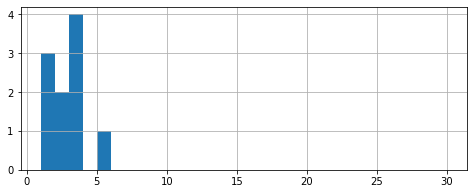

In [11]:
Results.loc[Results.PlayoffResult=='Champ'].TeamRank.hist(bins=range(1,31),xlabelsize=10,figsize=(8,3))

In [23]:
#Results.to_csv('NBA_Simulation_Results.csv')